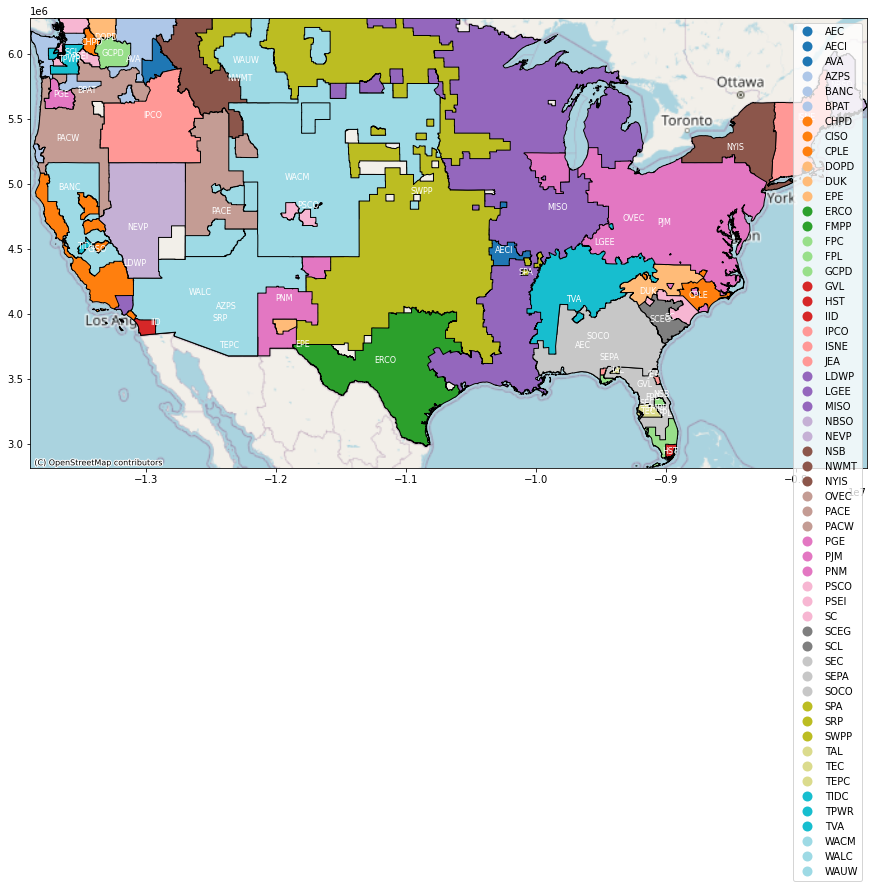

/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_1740/2314216868.py:137: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ba_areas.to_file(output_dir+'/Balance_auth_shapefile_by_county/ba_areas.shp')


In [8]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

# Assuming data_and_output_dir is defined and contains the path to your data directory
data_and_output_dir = '/Users/ansonkong/Downloads/Data for nyu work/'  # Update this path
output_dir='/Users/ansonkong/Downloads/NYU_WORK_REPO/share'
# Path to the shapefile and CSV
shapefile_path = data_and_output_dir + 'Input/cb_2018_us_county_500k/cb_2018_us_county_500k.shp'
csv_path = data_and_output_dir + 'Input/service_area/ba_service_territory_2020.csv'
mainland_fips_ranges = [
    (1001, 1999),  # Alabama
    (4001, 4999),  # Arizona
    (5001, 5999),  # Arkansas
    (6001, 6999),  # California
    (8001, 8999),  # Colorado
    (9001, 9999),  # Connecticut
    (10001, 10999),  # Delaware
    (11001, 11999),  # District of Columbia
    (12001, 12999),  # Florida
    (13001, 13999),  # Georgia
    (16001, 16999),  # Idaho
    (17001, 17999),  # Illinois
    (18001, 18999),  # Indiana
    (19001, 19999),  # Iowa
    (20001, 20999),  # Kansas
    (21001, 21999),  # Kentucky
    (22001, 22999),  # Louisiana
    (23001, 23999),  # Maine
    (24001, 24999),  # Maryland
    (25001, 25999),  # Massachusetts
    (26001, 26999),  # Michigan
    (27001, 27999),  # Minnesota
    (28001, 28999),  # Mississippi
    (29001, 29999),  # Missouri
    (30001, 30999),  # Montana
    (31001, 31999),  # Nebraska
    (32001, 32999),  # Nevada
    (33001, 33999),  # New Hampshire
    (34001, 34999),  # New Jersey
    (35001, 35999),  # New Mexico
    (36001, 36999),  # New York
    (37001, 37999),  # North Carolina
    (38001, 38999),  # North Dakota
    (39001, 39999),  # Ohio
    (40001, 40999),  # Oklahoma
    (41001, 41999),  # Oregon
    (42001, 42999),  # Pennsylvania
    (44001, 44999),  # Rhode Island
    (45001, 45999),  # South Carolina
    (46001, 46999),  # South Dakota
    (47001, 47999),  # Tennessee
    (48001, 48999),  # Texas
    (49001, 49999),  # Utah
    (50001, 50999),  # Vermont
    (51001, 51999),  # Virginia
    (53001, 53999),  # Washington
    (54001, 54999),  # West Virginia
    (55001, 55999),  # Wisconsin
    (56001, 56999)  # Wyoming
]

# Assuming the rest of the script remains the same...

# Adjust the function to work with strings
def is_in_mainland_ranges(geoid_str, ranges):
    geoid = int(geoid_str)  # Convert to integer for comparison
    for start, end in ranges:
        if start <= geoid <= end:
            return True
    return False

# Read the shapefile using GeoPandas
gdf = gpd.read_file(shapefile_path)

# Read the CSV file
df = pd.read_csv(csv_path)

# Convert County_FIPS to string and ensure it's zero-padded to 5 digits
df['GEOID'] = df['County_FIPS'].apply(lambda x: str(x).zfill(5))

# Filter df to include only rows with GEOID in the specified mainland FIPS ranges
# Note: Now 'GEOID' in df is already a string, so we keep it consistent.
df = df[df['GEOID'].apply(lambda geoid: is_in_mainland_ranges(geoid, mainland_fips_ranges))]

# Ensure 'GEOID' in gdf is also a string to match types during merge
gdf['GEOID'] = gdf['GEOID'].astype(str)

# Convert GEOID in both gdf and df to string for consistency
gdf['GEOID'] = gdf['GEOID'].astype(str)
df['GEOID'] = df['GEOID'].astype(str)

# Now proceed to merge - both GEOID columns are strings
merged_gdf = gdf.merge(df, on='GEOID')



# Check and fix invalid geometries if necessary
invalid_geometries = merged_gdf[~merged_gdf.is_valid]
if invalid_geometries.shape[0] > 0:
    merged_gdf = merged_gdf.buffer(0)

# Aggregate (dissolve) geometries by BA_Code to get a single geometry per BA_Code
ba_areas = merged_gdf.dissolve(by='BA_Code', as_index=False)


# Convert the CRS of ba_areas to EPSG:3857 for contextily
ba_areas = ba_areas.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Use a more diverse colormap, for example, 'tab20', 'Set3', or define your own
# 'tab20' is good for up to 20 distinct categories; for more categories, consider other options or custom colormaps
ba_areas.plot(ax=ax, column='BA_Code', edgecolor='black', linewidth=1, legend=True, cmap='tab20', legend_kwds={'bbox_to_anchor': (1, 1)})

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Plot each BA_Code area with label - using representative_point for label placement
for idx, row in ba_areas.iterrows():
    # Use representative_point() for potentially better label placement
    rep_point = row.geometry.representative_point()
    plt.text(rep_point.x, rep_point.y, row['BA_Code'], fontsize=8, ha='center', va='center', color='white')

# Adjust the axis to the bounds of your geodataframe if valid
if not np.any(np.isnan(ba_areas.total_bounds)) and not np.any(np.isinf(ba_areas.total_bounds)):
    ax.set_xlim(ba_areas.total_bounds[[0, 2]])
    ax.set_ylim(ba_areas.total_bounds[[1, 3]])

plt.show()


# Save ba_areas as a shapefile
ba_areas.to_file(output_dir+'/Balance_auth_shapefile_by_county/ba_areas.shp')


For the above methord, I use the tell model provided BA to county file and county shape file by cencus to generate the shape of BA
If you are interested in the subregion, the two folling methord may interest you, both of them I try to seperate the region using the mapping provided by the ReEDS model, the different between them is the BA definintie is different, the later use the same defintion and prior come from (https://hifld-geoplatform.hub.arcgis.com/datasets/geoplatform::control-areas/explore?location=33.336357%2C-112.615515%2C3.65), it was called contral area

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


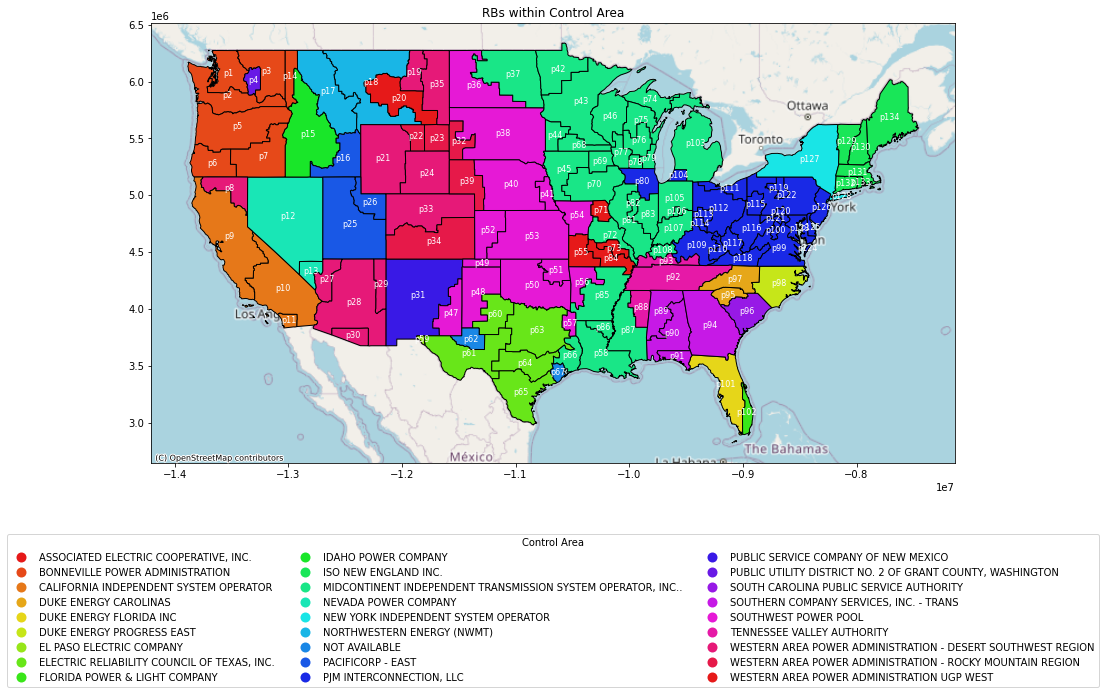

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from matplotlib.colors import LinearSegmentedColormap
from colorsys import hls_to_rgb
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import netCDF4 as nc
import numpy as np
from shapely import wkt
import matplotlib.pyplot as plt
import contextily as ctx

control_area_path = data_and_output_dir + 'input/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
nc_file_path = data_and_output_dir + 'input/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'
base_file_path = data_and_output_dir + 'input/US_CAN_MEX_PCA_polygons.csv'




control_areas_gdf = gpd.read_file(control_area_path).to_crs(epsg=4326)

base_df = pd.read_csv(base_file_path)
# Assuming 'WKT' column exists and contains geometries
base_df['geometry'] = base_df['WKT'].apply(wkt.loads)
base_gdf = gpd.GeoDataFrame(base_df, geometry='geometry', crs='EPSG:4326')

ds = nc.Dataset(nc_file_path, 'r')
time_step = 0  # Adjust based on your needs
lats = ds.variables['XLAT'][time_step, :, :]
lons = ds.variables['XLONG'][time_step, :, :]
points_geometry = [Point(lon, lat) for lat, lon in zip(np.ravel(lats), np.ravel(lons))]
gdf_points = gpd.GeoDataFrame(geometry=points_geometry, crs='EPSG:4326')

# Assuming 'rb' is a column in base_gdf
gdf_points_with_rb = gpd.sjoin(gdf_points, base_gdf[['geometry', 'rb']], how='inner', op='intersects')

# Drop 'index_left' and 'index_right' columns if they exist
if 'index_left' in gdf_points_with_rb.columns:
    gdf_points_with_rb.drop(columns=['index_left'], inplace=True)
if 'index_right' in gdf_points_with_rb.columns:
    gdf_points_with_rb.drop(columns=['index_right'], inplace=True)

# Now perform the spatial join again
gdf_points_with_control_area = gpd.sjoin(gdf_points_with_rb, control_areas_gdf, how='inner', op='intersects')

# Group by 'rb' to determine the majority control area
majority_control_area_by_rb = gdf_points_with_control_area.groupby('rb')['CNTRL_AREA'].agg(lambda x: x.mode()[0] if not x.empty else 'No Control Area').reset_index()

# Use 'CNTRL_AREA' from control_areas_gdf for grouping

for index, row in base_gdf.iterrows():
    if row['rb'] not in majority_control_area_by_rb['rb'].values:
        # Check if RB is fully within a control area
        contained_areas = control_areas_gdf[control_areas_gdf.contains(row['geometry'])]['CNTRL_AREA'].unique()
        if len(contained_areas) == 1:
            # Add directly to majority_control_area_by_rb DataFrame
            new_row = {'rb': row['rb'], 'CNTRL_AREA': contained_areas[0]}
            majority_control_area_by_rb = majority_control_area_by_rb.append(new_row, ignore_index=True)
# Assuming base_df is already loaded
base_df['geometry'] = base_df['WKT'].apply(wkt.loads)
base_gdf = gpd.GeoDataFrame(base_df, geometry='geometry', crs='EPSG:4326')
# Ensure the 'rb' column is the same type in both DataFrames
base_gdf['rb'] = base_gdf['rb'].astype(str)
majority_control_area_by_rb['rb'] = majority_control_area_by_rb['rb'].astype(str)

# Merge to associate each RB geometry with its majority control area
rb_with_control_area = base_gdf[['rb', 'geometry']].merge(majority_control_area_by_rb, on='rb')
# Filter RBs from p1 to p134
rb_filtered = rb_with_control_area[rb_with_control_area['rb'].isin([f'p{i}' for i in range(1, 135)])]

# Convert to Web Mercator
rb_filtered_crs = rb_filtered.to_crs(epsg=3857)



# Function to generate a wide-range colormap
def generate_colormap(n_colors):
    colors = []
    for i in np.linspace(0, 1, n_colors):
        h = i  # Hue
        l = 0.5  # Lightness
        s = 0.8  # Saturation
        rgb = hls_to_rgb(h, l, s)
        colors.append(rgb)
    return LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_colors)

# Assuming rb_filtered_crs is your GeoDataFrame ready for plotting
num_unique_areas = rb_filtered_crs['CNTRL_AREA'].nunique()
custom_cmap = generate_colormap(num_unique_areas)

fig, ax = plt.subplots(figsize=(15, 10))

# Plot using the generated custom colormap
rb_filtered_crs.plot(ax=ax, column='CNTRL_AREA', legend=True, cmap=custom_cmap,
                     edgecolor='black', linewidth=1,
                     legend_kwds={'loc': 'upper center', 'bbox_to_anchor': (0.5, -0.15), 'ncol': 3, 'title': 'Control Area'})

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=rb_filtered_crs.crs.to_string())
ax.set_title('RBs within Control Area')

for idx, row in rb_filtered_crs.iterrows():
    centroid = row.geometry.centroid.coords[0]
    plt.text(centroid[0], centroid[1], row['rb'], fontsize=8, ha='center', va='center', color='white')

plt.tight_layout()
plt.show()

rb_filtered_crs.to_file(output_dir+'/contral_area_shapefile_by_rb/rb_and_contral_area_areas.shp')

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


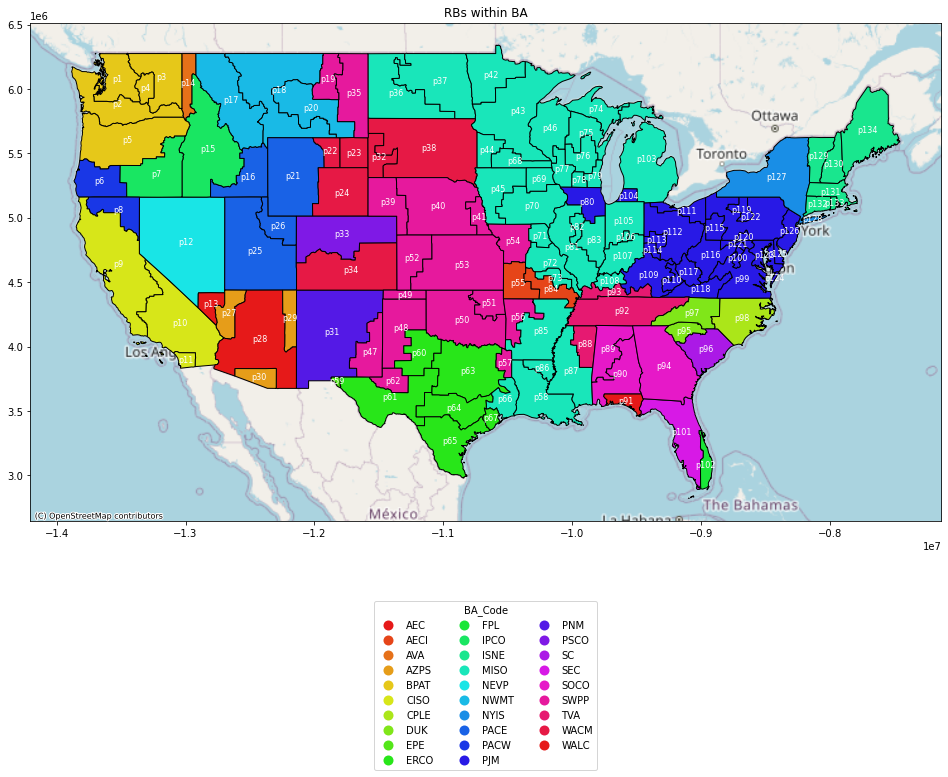

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from matplotlib.colors import LinearSegmentedColormap
from colorsys import hls_to_rgb
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import netCDF4 as nc
import numpy as np
from shapely import wkt
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

# Assuming data_and_output_dir is defined and contains the path to your data directory

# Path to the shapefile and CSV
shapefile_path = data_and_output_dir + 'Input/cb_2018_us_county_500k/cb_2018_us_county_500k.shp'
csv_path = data_and_output_dir + 'Input/service_area/ba_service_territory_2020.csv'
mainland_fips_ranges = [
    (1001, 1999),  # Alabama
    (4001, 4999),  # Arizona
    (5001, 5999),  # Arkansas
    (6001, 6999),  # California
    (8001, 8999),  # Colorado
    (9001, 9999),  # Connecticut
    (10001, 10999),  # Delaware
    (11001, 11999),  # District of Columbia
    (12001, 12999),  # Florida
    (13001, 13999),  # Georgia
    (16001, 16999),  # Idaho
    (17001, 17999),  # Illinois
    (18001, 18999),  # Indiana
    (19001, 19999),  # Iowa
    (20001, 20999),  # Kansas
    (21001, 21999),  # Kentucky
    (22001, 22999),  # Louisiana
    (23001, 23999),  # Maine
    (24001, 24999),  # Maryland
    (25001, 25999),  # Massachusetts
    (26001, 26999),  # Michigan
    (27001, 27999),  # Minnesota
    (28001, 28999),  # Mississippi
    (29001, 29999),  # Missouri
    (30001, 30999),  # Montana
    (31001, 31999),  # Nebraska
    (32001, 32999),  # Nevada
    (33001, 33999),  # New Hampshire
    (34001, 34999),  # New Jersey
    (35001, 35999),  # New Mexico
    (36001, 36999),  # New York
    (37001, 37999),  # North Carolina
    (38001, 38999),  # North Dakota
    (39001, 39999),  # Ohio
    (40001, 40999),  # Oklahoma
    (41001, 41999),  # Oregon
    (42001, 42999),  # Pennsylvania
    (44001, 44999),  # Rhode Island
    (45001, 45999),  # South Carolina
    (46001, 46999),  # South Dakota
    (47001, 47999),  # Tennessee
    (48001, 48999),  # Texas
    (49001, 49999),  # Utah
    (50001, 50999),  # Vermont
    (51001, 51999),  # Virginia
    (53001, 53999),  # Washington
    (54001, 54999),  # West Virginia
    (55001, 55999),  # Wisconsin
    (56001, 56999)  # Wyoming
]

# Assuming the rest of the script remains the same...

# Adjust the function to work with strings
def is_in_mainland_ranges(geoid_str, ranges):
    geoid = int(geoid_str)  # Convert to integer for comparison
    for start, end in ranges:
        if start <= geoid <= end:
            return True
    return False

# Read the shapefile using GeoPandas
gdf = gpd.read_file(shapefile_path)

# Read the CSV file
df = pd.read_csv(csv_path)

# Convert County_FIPS to string and ensure it's zero-padded to 5 digits
df['GEOID'] = df['County_FIPS'].apply(lambda x: str(x).zfill(5))

# Filter df to include only rows with GEOID in the specified mainland FIPS ranges
# Note: Now 'GEOID' in df is already a string, so we keep it consistent.
df = df[df['GEOID'].apply(lambda geoid: is_in_mainland_ranges(geoid, mainland_fips_ranges))]

# Ensure 'GEOID' in gdf is also a string to match types during merge
gdf['GEOID'] = gdf['GEOID'].astype(str)

# Convert GEOID in both gdf and df to string for consistency
gdf['GEOID'] = gdf['GEOID'].astype(str)
df['GEOID'] = df['GEOID'].astype(str)

# Now proceed to merge - both GEOID columns are strings
merged_gdf = gdf.merge(df, on='GEOID')



# Check and fix invalid geometries if necessary
invalid_geometries = merged_gdf[~merged_gdf.is_valid]
if invalid_geometries.shape[0] > 0:
    merged_gdf = merged_gdf.buffer(0)

# Aggregate (dissolve) geometries by BA_Code to get a single geometry per BA_Code
ba_areas = merged_gdf.dissolve(by='BA_Code', as_index=False)


# Convert the CRS of ba_areas to EPSG:4326 for contextily
ba_areas = ba_areas.to_crs(epsg=4326)

nc_file_path = data_and_output_dir + 'input/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'
base_file_path = data_and_output_dir + 'input/US_CAN_MEX_PCA_polygons.csv'

base_df = pd.read_csv(base_file_path)
# Assuming 'WKT' column exists and contains geometries
base_df['geometry'] = base_df['WKT'].apply(wkt.loads)
base_gdf = gpd.GeoDataFrame(base_df, geometry='geometry', crs='EPSG:4326')

ds = nc.Dataset(nc_file_path, 'r')
time_step = 0  # Adjust based on your needs
lats = ds.variables['XLAT'][time_step, :, :]
lons = ds.variables['XLONG'][time_step, :, :]
points_geometry = [Point(lon, lat) for lat, lon in zip(np.ravel(lats), np.ravel(lons))]
gdf_points = gpd.GeoDataFrame(geometry=points_geometry, crs='EPSG:4326')

# Assuming 'rb' is a column in base_gdf
gdf_points_with_rb = gpd.sjoin(gdf_points, base_gdf[['geometry', 'rb']], how='inner', op='intersects')

# Drop 'index_left' and 'index_right' columns if they exist
if 'index_left' in gdf_points_with_rb.columns:
    gdf_points_with_rb.drop(columns=['index_left'], inplace=True)
if 'index_right' in gdf_points_with_rb.columns:
    gdf_points_with_rb.drop(columns=['index_right'], inplace=True)

# Now perform the spatial join again
gdf_points_with_ba = gpd.sjoin(gdf_points_with_rb, ba_areas, how='inner', op='intersects')

# Group by 'rb' to determine the majority control area
majority_ba_by_rb = gdf_points_with_ba.groupby('rb')['BA_Code'].agg(lambda x: x.mode()[0] if not x.empty else 'No BA').reset_index()

# Use 'CNTRL_AREA' from control_areas_gdf for grouping

for index, row in base_gdf.iterrows():
    if row['rb'] not in majority_ba_by_rb['rb'].values:
        # Check if RB is fully within a control area
        contained_areas = ba_areas[ba_areas.contains(row['geometry'])]['BA_Code'].unique()
        if len(contained_areas) == 1:
            # Add directly to majority_control_area_by_rb DataFrame
            new_row = {'rb': row['rb'], 'BA_Code': contained_areas[0]}
            majority_ba_by_rb = majority_ba_by_rb.append(new_row, ignore_index=True)
# Assuming base_df is already loaded
base_df['geometry'] = base_df['WKT'].apply(wkt.loads)
base_gdf = gpd.GeoDataFrame(base_df, geometry='geometry', crs='EPSG:4326')
# Ensure the 'rb' column is the same type in both DataFrames
base_gdf['rb'] = base_gdf['rb'].astype(str)
majority_ba_by_rb['rb'] = majority_ba_by_rb['rb'].astype(str)

# Merge to associate each RB geometry with its majority control area
rb_with_ba = base_gdf[['rb', 'geometry']].merge(majority_ba_by_rb, on='rb')
# Filter RBs from p1 to p134
rb_with_ba_filtered = rb_with_ba[rb_with_ba['rb'].isin([f'p{i}' for i in range(1, 135)])]

# Convert to Web Mercator
rb_with_ba_filtered = rb_with_ba_filtered.to_crs(epsg=3857)



# Function to generate a wide-range colormap
def generate_colormap(n_colors):
    colors = []
    for i in np.linspace(0, 1, n_colors):
        h = i  # Hue
        l = 0.5  # Lightness
        s = 0.8  # Saturation
        rgb = hls_to_rgb(h, l, s)
        colors.append(rgb)
    return LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_colors)

# Assuming rb_filtered_crs is your GeoDataFrame ready for plotting
num_unique_areas = rb_with_ba_filtered['BA_Code'].nunique()
custom_cmap = generate_colormap(num_unique_areas)

fig, ax = plt.subplots(figsize=(15, 10))

# Plot using the generated custom colormap
rb_with_ba_filtered.plot(ax=ax, column='BA_Code', legend=True, cmap=custom_cmap,
                     edgecolor='black', linewidth=1,
                     legend_kwds={'loc': 'upper center', 'bbox_to_anchor': (0.5, -0.15), 'ncol': 3, 'title':'BA_Code'})

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=rb_filtered_crs.crs.to_string())
ax.set_title('RBs within BA')

for idx, row in rb_filtered_crs.iterrows():
    centroid = row.geometry.centroid.coords[0]
    plt.text(centroid[0], centroid[1], row['rb'], fontsize=8, ha='center', va='center', color='white')

plt.tight_layout()
plt.show()

rb_with_ba_filtered.to_file(output_dir+'/Balance_auth_shapefile_by_rb/rb_and_ba_areas.shp')